## Avaliação em holdouts - Movielens

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
## Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/movielens_dump/sampled_movielens.csv')

In [5]:
user_col = 'UserID'
item_col = 'ItemID'

### Convert timestamp

In [6]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 395 ms, sys: 225 µs, total: 396 ms
Wall time: 393 ms


In [7]:
data['timestamp'] = data['Timestamp']

# Hyperparameters

In [8]:
# print( grid[ np.argmax( results ) ] ) # from 6 months (150, 2, 0.5, 0.5) # from 3 months (150, 8, 0.25, 0.25)
num_factors, num_iter, learn_rate, regularization = (150, 2, 0.5, 0.5) #grid[ np.argmax( results ) ]

# EXPERIMENT 1

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETSLAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  

In [9]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

print('Removing seen examples from buckets')

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b


Creating buckets. . .
Creating holdouts. . .
Removing seen examples from buckets


In [10]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [11]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50742

In [12]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [13]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [14]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2630
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3440
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2920
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 6min 4s, sys: 17min 39s, total: 23min 44s
Wall time: 1min 42s


In [15]:
rm = eval.results_matrix
df_exp1 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 1

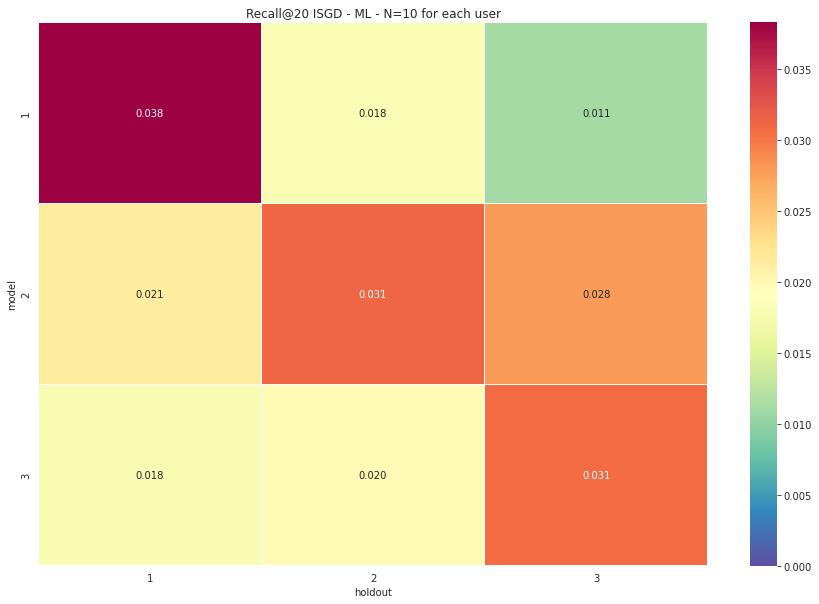

In [16]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp1,
    round_point=3,
    title='Recall@20 ISGD - ML - N=10 for each user',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [17]:
arecall = avg_recall(df_exp1)
arecall

0.03339808436768604

In [18]:
BWT, meanBWT = compute_BWT(df_exp1)
BWT, meanBWT

([-0.016865079365079368, -0.01592813051146385], -0.01639660493827161)

In [19]:
FWT = compute_FWT(df_exp1)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.018997333087393264

# EXPERIMENT 2

CODE TO GET LAST N ITEMS AS HOLDOUT
INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

In [20]:
# CODE TO GET LAST N ITEMS AS HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        # print(buckets[i].shape)

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b

Creating buckets. . .
Creating holdouts. . .


In [21]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [22]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50712

In [23]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(20967, 695, 2056), (13138, 458, 1778), (16607, 455, 1920)]

In [37]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]
# HOLDOUT IS EMPTY!?

[(0, 0, 0), (0, 0, 0), (0, 0, 0)]

In [31]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [32]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [33]:
# %%time
# # HOLDOUT IS EMPTY!!!!!!!!!!!!!!!
# # 28min 20s
# eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')
# rm = eval.results_matrix
# df_exp2 = pd.DataFrame(rm)
# # df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0


ZeroDivisionError: division by zero

# Result EXP 2

In [38]:
# # result with N=10 last interactions
# # items in holdout are removed from training
# recall_heatmap(df_exp2,
#     round_point=3,
#     title='Recall@20 ISGD - ML - N=10 last interactions overall',
#     filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [39]:
# arecall = avg_recall(df_exp2)
# arecall

In [40]:
# BWT, meanBWT = compute_BWT(df_exp2)
# BWT, meanBWT

In [41]:
# FWT = compute_FWT(df_exp2)
# FWT
# # que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

# EXPERIMENT 3

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETSLAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED

In [42]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

print('Removing seen examples from buckets')

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b


Creating buckets. . .
Creating holdouts. . .
Removing seen examples from buckets


In [43]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [44]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50742

In [45]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [46]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [47]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2630
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3440
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2920
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 4min 13s, sys: 11min 40s, total: 15min 54s
Wall time: 1min 12s


In [48]:
rm = eval.results_matrix
df_exp3 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 3

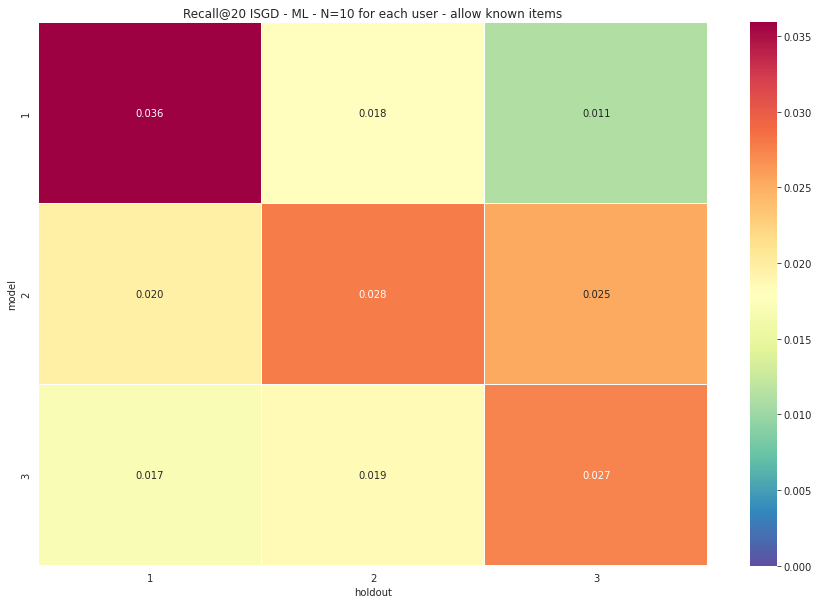

In [49]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp3,
    round_point=3,
    title='Recall@20 ISGD - ML - N=10 for each user - allow known items',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [50]:
arecall = avg_recall(df_exp3)
arecall

0.030394579215333933

In [51]:
BWT, meanBWT = compute_BWT(df_exp3)
BWT, meanBWT

([-0.016269841269841268, -0.014054232804232803], -0.015162037037037036)

In [52]:
FWT = compute_FWT(df_exp3)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.01815345123085318

# EXPERIMENT 4

CODE TO GET LAST N ITEMS AS HOLDOUT  
* INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS
* RECOMENDING SEEN ITEMS IS ALLOWED

In [53]:
# CODE TO GET LAST N ITEMS AS HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        # print(buckets[i].shape)

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b

Creating buckets. . .
Creating holdouts. . .


In [54]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [55]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50712

In [56]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(20967, 695, 2056), (13138, 458, 1778), (16607, 455, 1920)]

In [58]:
# EMPTY HOLDOUT
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(0, 0, 0), (0, 0, 0), (0, 0, 0)]

In [59]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [60]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [61]:
# %%time
# # 28min 20s
# eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

In [62]:
# rm = eval.results_matrix
# df_exp4 = pd.DataFrame(rm)
# # df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 4

In [63]:
# # result with N=10 last interactions
# # items in holdout are removed from training
# recall_heatmap(df_exp4,
#     round_point=3,
#     title='Recall@20 ISGD - ML - N=10 last interactions overall - known items allowed',
#     filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [64]:
# arecall = avg_recall(df_exp4)
# arecall

In [65]:
# BWT, meanBWT = compute_BWT(df_exp4)
# BWT, meanBWT

In [66]:
# FWT = compute_FWT(df_exp4)
# FWT
# # que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

# EXPERIMENT 5

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS

In [67]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [68]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [69]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

50742

In [70]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [71]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [72]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2630
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3440
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2920
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 6min 40s, sys: 19min 43s, total: 26min 24s
Wall time: 1min 53s


In [73]:
rm = eval.results_matrix
df_exp5 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 5

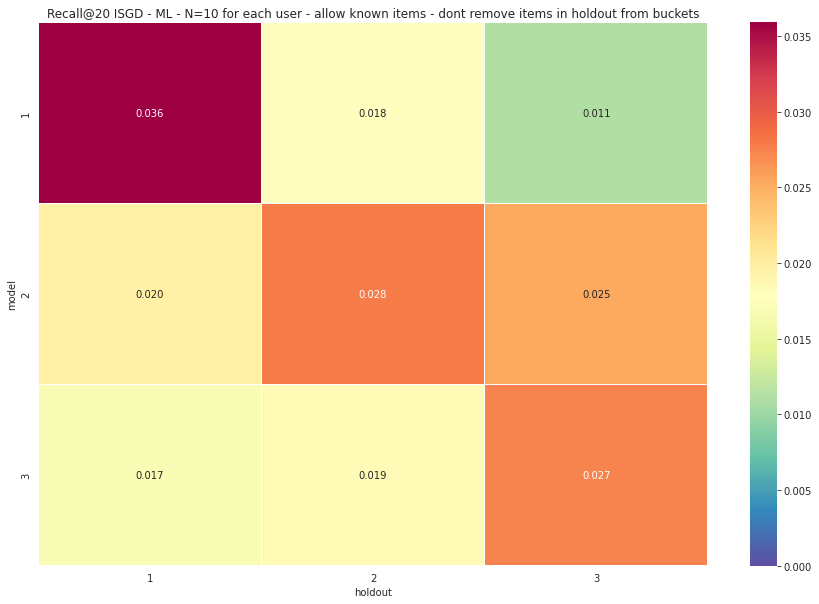

In [74]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp5,
    round_point=3,
    title='Recall@20 ISGD - ML - N=10 for each user - allow known items - dont remove items in holdout from buckets',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [75]:
arecall = avg_recall(df_exp5)
arecall

0.030394579215333933

In [76]:
BWT, meanBWT = compute_BWT(df_exp5)
BWT, meanBWT

([-0.016269841269841268, -0.014054232804232803], -0.015162037037037036)

In [77]:
FWT = compute_FWT(df_exp5)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.01815345123085318

# EXPERIMENT 6

CODE TO GET LAST N ITEMS AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS FROM HOLDOUTS FROM BUCKETS

In [ ]:
# # CODE TO GET LAST N ITEMS AS HOLDOUT
# # INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

# N = 10
# cold_start_buckets = 0
# #     print('0',data.shape[0]) # debug
# print('Creating buckets. . .')
# buckets = []
# # assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# # create buckets based on months
# months = data['date'].unique()
# for interval in months:
#     idx = (data['date'] == interval)
#     buckets.append( data[idx] )

# print('Creating holdouts. . .')
# # create holdouts with last user interaction
# holdouts = []
# frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# # Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
# for i, b in enumerate( buckets ):
#     if i >= cold_start_buckets:
#         interaction_idx = []
#         tail = b.tail(N)
#         for idx, example in tail.iterrows():
#             user = example[user_col]
#             if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
#                 if user not in frequent_users_seen:
#                     frequent_users_seen.append(user)
#                 interaction_idx.append(idx)
#         holdout = b.loc[interaction_idx].reset_index(drop=True)
#         # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
#         # print( holdout.shape)
#         holdouts.append(holdout)
#         buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
#         # print(buckets[i].shape)

Creating buckets. . .
Creating holdouts. . .


In [78]:
# print('Converting to ImplicitData. . .')
# for i, b in enumerate(buckets):
#     buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

# for j, h in enumerate(holdouts):
#     holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

# print('Done!')
# # return buckets, holdouts

In [79]:
# sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

In [80]:
# [(b.size, len(b.userset), len(b.itemset)) for b in buckets]

In [81]:
# [(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

In [82]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# # stream = ImplicitData(data[user_col], data[item_col])
# # O modelo deve ser iniciado com uma lista vazia
# empty_stream = ImplicitData([], [])
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [83]:
# # criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
# eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [84]:
# %%time
# # 28min 20s
# eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

In [85]:
# rm = eval.results_matrix
# df_exp6 = pd.DataFrame(rm)
# # df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 6

In [86]:
# # result with N=10 last interactions
# # items in holdout are removed from training
# recall_heatmap(df_exp6,
#     round_point=3,
#     title='Recall@20 ISGD - ML - N=10 last interactions overall - known items allowed - dont remove items in holdout from buckets',
#     filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [87]:
# arecall = avg_recall(df_exp6)
# arecall

In [88]:
# BWT, meanBWT = compute_BWT(df_exp6)
# BWT, meanBWT

In [89]:
# FWT = compute_FWT(df_exp6)
# FWT
# # que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

# EXPERIMENT 7

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [90]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [91]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [92]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

62732

In [93]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [94]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [95]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2630
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3440
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2920
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 5min 56s, sys: 16min 33s, total: 22min 29s
Wall time: 1min 42s


In [96]:
rm = eval.results_matrix
df_exp7 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 7

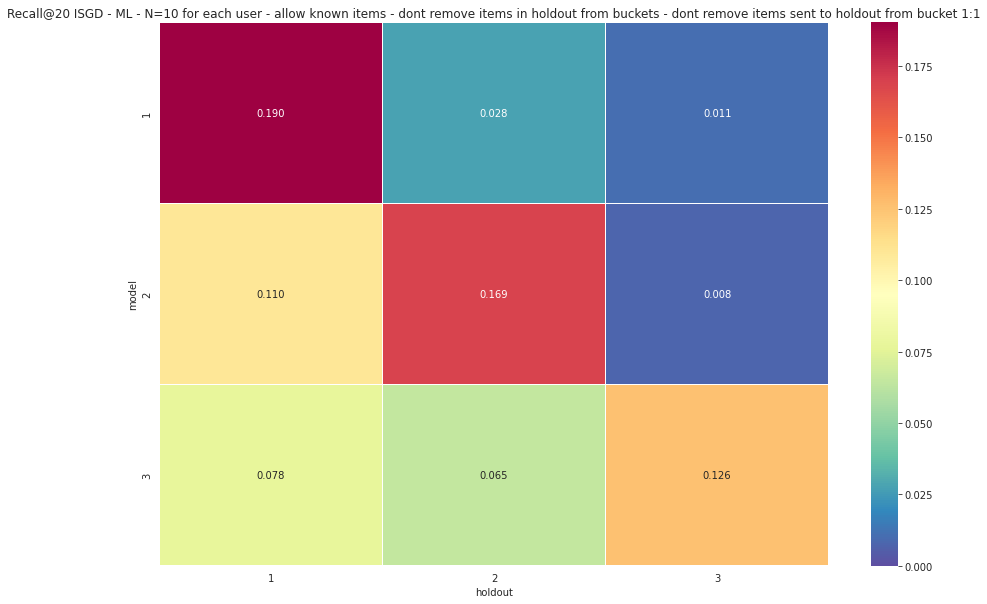

In [97]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp7,
    round_point=3,
    title='Recall@20 ISGD - ML - N=10 for each user - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [98]:
arecall = avg_recall(df_exp7)
arecall

0.16176319700952826

In [99]:
BWT, meanBWT = compute_BWT(df_exp7)
BWT, meanBWT

([-0.08055555555555555, -0.1084104938271605], -0.09448302469135803)

In [100]:
FWT = compute_FWT(df_exp7)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.015524966759662756

# EXPERIMENT 8

CODE TO GET LAST N ITEMS AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS FROM HOLDOUTS FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [101]:
# # CODE TO GET LAST N ITEMS AS HOLDOUT

# N = 10
# cold_start_buckets = 0
# #     print('0',data.shape[0]) # debug
# print('Creating buckets. . .')
# buckets = []
# # assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# # create buckets based on months
# months = data['date'].unique()
# for interval in months:
#     idx = (data['date'] == interval)
#     buckets.append( data[idx] )

# print('Creating holdouts. . .')
# # create holdouts with last user interaction
# holdouts = []
# frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# # Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
# for i, b in enumerate( buckets ):
#     if i >= cold_start_buckets:
#         interaction_idx = []
#         tail = b.tail(N)
#         for idx, example in tail.iterrows():
#             user = example[user_col]
#             if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
#                 if user not in frequent_users_seen:
#                     frequent_users_seen.append(user)
#                 interaction_idx.append(idx)
#         holdout = b.loc[interaction_idx].reset_index(drop=True)
#         # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
#         # print( holdout.shape)
#         holdouts.append(holdout)
#         # buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
#         buckets[i] = b.reset_index(drop=True)
#         # print(buckets[i].shape)

In [ ]:
# print('Converting to ImplicitData. . .')
# for i, b in enumerate(buckets):
#     buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

# for j, h in enumerate(holdouts):
#     holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

# print('Done!')
# # return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [ ]:
# sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

435661

In [ ]:
# [(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(79012, 1248, 10035),
 (111340, 1392, 12731),
 (132840, 1499, 12773),
 (112429, 1577, 14074)]

In [ ]:
# [(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 2, 10), (10, 3, 4), (10, 7, 10), (10, 4, 10)]

In [ ]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# # stream = ImplicitData(data[user_col], data[item_col])
# # O modelo deve ser iniciado com uma lista vazia
# empty_stream = ImplicitData([], [])
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# # criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
# eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [ ]:
# %%time
# # 28min 20s
# eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 6
Test Holdout 3
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 6
Test Holdout 3
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
Test Holdout 3
----------------------------------------------------------------------------------------------------
Train bucket 3
Test Holdout 0
Test Holdout 1
Test Holdout 2
Test Holdout 3
CPU times: user 9min 52s, sys: 29.6 s, total: 10min 22s
Wall time: 9min 43s


In [ ]:
# rm = eval.results_matrix
# df_exp8 = pd.DataFrame(rm)
# # df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 8

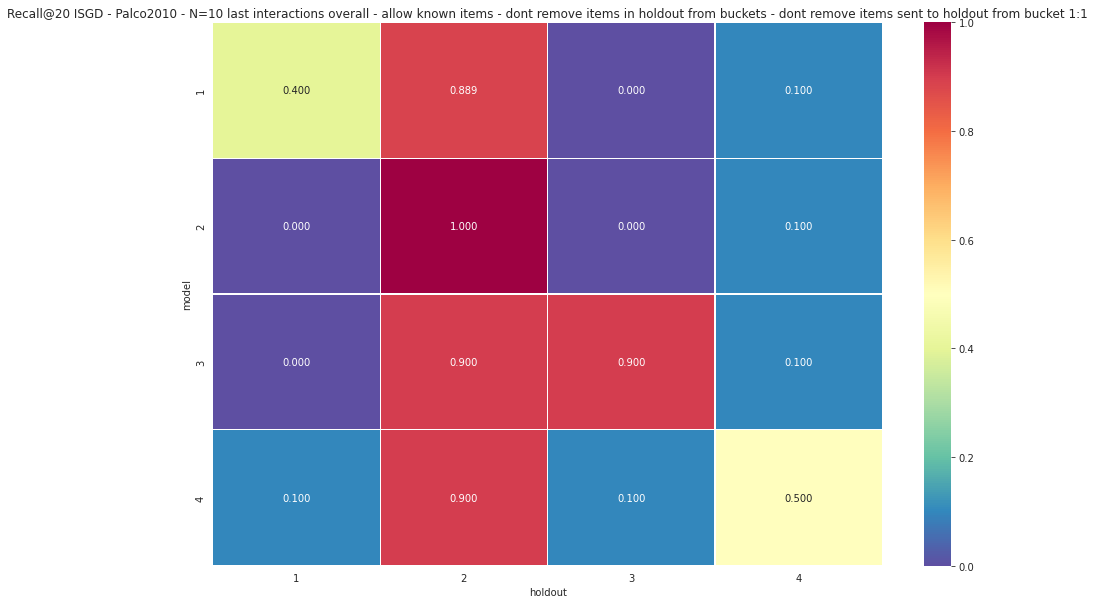

In [ ]:
# # result with N=10 last interactions
# # items in holdout are removed from training
# recall_heatmap(df_exp8,
#     round_point=3,
#     title='Recall@20 ISGD - ML - N=10 last interactions overall - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
#     filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [102]:
# arecall = avg_recall(df_exp8)
# arecall

In [ ]:
# BWT, meanBWT = compute_BWT(df_exp8)
# BWT, meanBWT

([-0.4, -0.25, -0.4000000000000001], -0.35000000000000003)

In [ ]:
# FWT = compute_FWT(df_exp8)
# FWT
# # que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.19814814814814816

# EXPERIMENT 9

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* 10 INTERACTIONS FROM EACH USER AS HOLDOUT - **RANDOMLY SAMPLED**
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [103]:
# CODE TO GET N INTERACTIONS FROM EACH USER AS HOLDOUT

np.random.seed(42)
N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            all_idx = list( b[b[user_col] == u].index )
            sample_idx = np.random.choice(a=all_idx, size=N, replace=False)
            holdout_idx += list( sample_idx )
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .
256
205
199
198
178
171
171
165
163
163
153
148
148
139
137
132
132
130
129
124
123
118
116
115
112
110
108
106
104
104
99
98
98
96
95
94
94
94
93
92
87
87
86
84
83
82
82
82
82
81
79
77
77
77
77
76
76
75
75
74
73
73
73
71
71
70
69
69
69
68
68
68
67
66
65
64
63
63
62
62
62
61
59
59
58
58
58
58
57
57
57
57
57
56
56
56
55
55
54
54
54
53
53
53
53
53
53
53
53
52
51
51
51
51
50
50
50
50
49
49
49
49
49
49
49
49
48
48
48
48
48
48
48
48
48
47
47
47
47
46
46
46
46
46
45
45
45
45
44
44
44
44
44
43
43
43
43
42
41
41
40
40
40
40
40
40
40
39
39
39
38
38
38
38
38
38
38
38
37
37
37
37
37
36
36
36
36
36
36
36
35
35
35
35
35
35
35
35
35
35
35
34
34
34
34
34
34
34
34
34
34
34
34
34
33
33
33
33
33
33
33
32
32
32
32
32
32
32
32
31
31
31
31
31
30
30
30
30
30
30
30
30
30
29
29
29
29
29
29
29
29
28
28
28
28
28
28
27
27
27
27
27
27
27
26
26
26
26
26
26
26
26
26
26
26
26
26
26
25
25
25
25
25
25
25
25
25
25
24
24
24
24
24
24
24
24
24
24
24
24
24
23
23
23
23
23
23
23
2

In [104]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [105]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

62732

In [106]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [107]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [108]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2630
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3440
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2920
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 7min 29s, sys: 21min 55s, total: 29min 24s
Wall time: 2min 9s


In [109]:
rm = eval.results_matrix
df_exp9 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_ML month_bucket ISGD results.csv', index=False)

# Result EXP 9

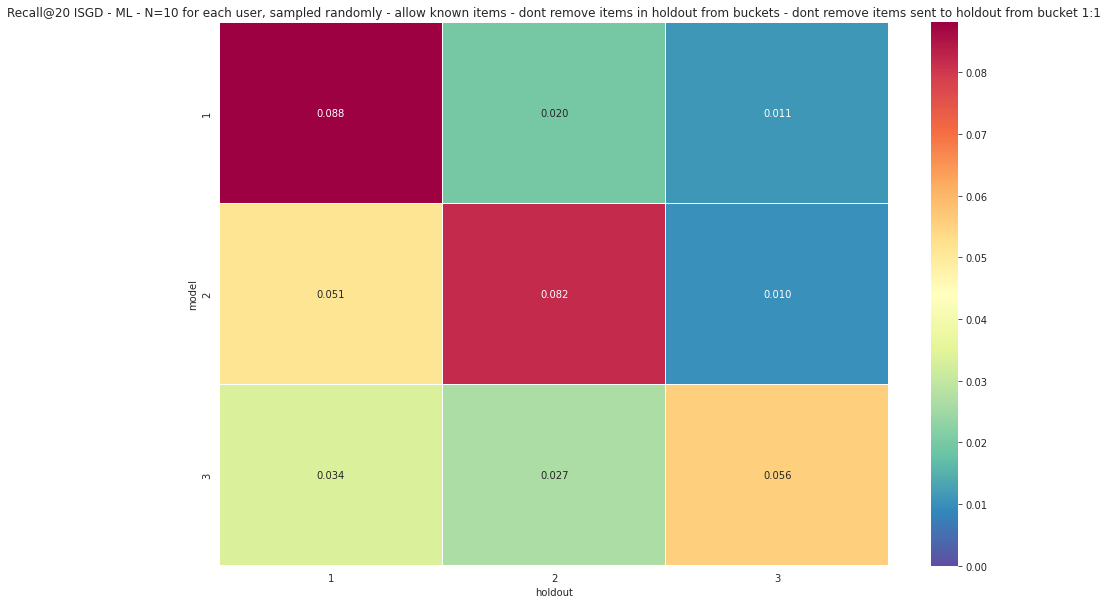

In [110]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp9,
    round_point=3,
    title='Recall@20 ISGD - ML - N=10 for each user, sampled randomly - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [111]:
arecall = avg_recall(df_exp9)
arecall

0.07523986999877987

In [112]:
BWT, meanBWT = compute_BWT(df_exp9)
BWT, meanBWT

([-0.036706349206349215, -0.05505952380952381], -0.04588293650793651)

In [113]:
FWT = compute_FWT(df_exp9)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.01363660817904437

# Store exp results

In [114]:
allresults = [df_exp1, df_exp3, df_exp5,df_exp7, df_exp9]

In [118]:
for r, n in zip( range(len(allresults)), range( 1, 10, 2)):
    allresults[r].to_csv(f'output_ML_10_examples/result_exp_{n}')

# Read results

In [119]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

* Exp1: 10 last examples of each user 
* Exp3: 10 last examples, and allow seen items
* Exp5: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp9: 10 randomly selected examples from each user, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [128]:
results_10_each_user = {}
for r in range( 9 ):
    if not (r+1)%2==0:
        results_10_each_user[r+1]=pd.read_csv(f'output_ML_10_examples/result_exp_{r+1}', index_col=0)

results_10_each_user = {
    k: {
        'avg_recall': avg_recall( results_10_each_user[k]),
        'BWT': compute_BWT( results_10_each_user[k] )[-1],
        'FWT': compute_FWT( results_10_each_user[k] )
        }
    for k in results_10_each_user.keys()
}

results_10_each_user = pd.DataFrame( results_10_each_user )

results_10_each_user

,1,3,5,7,9
avg_recall,0.033398,0.030395,0.030395,0.161763,0.075240
BWT,-0.016397,-0.015162,-0.015162,-0.094483,-0.045883
FWT,0.018997,0.018153,0.018153,0.015525,0.013637


In [121]:
# * Exp2: 10 last exaples, overall
# * Exp4: 10 last exaples, overall, and allow seen items
# * Exp6: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items
# * Exp8: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [122]:
# results_last_10 = {}
# for r in range( 9 ):
#     if (r+1)%2==0:
#         results_last_10[r+1]=pd.read_csv(f'output_p10_10_examples/result_exp_{r+1}', index_col=0)

# results_last_10 = {
#     k: {
#         'avg_recall': avg_recall( results_last_10[k]),
#         'BWT': compute_BWT( results_last_10[k] )[-1],
#         'FWT': compute_FWT( results_last_10[k] )
#         }
#     for k in results_last_10.keys()
# }

# results_last_10 = pd.DataFrame( results_last_10 )

# results_last_10

# ORIGINAL RESULT

In [64]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
# df.to_csv('output/movielens_dump/sample_movielens month_bucket ISGD results.csv', index=False)

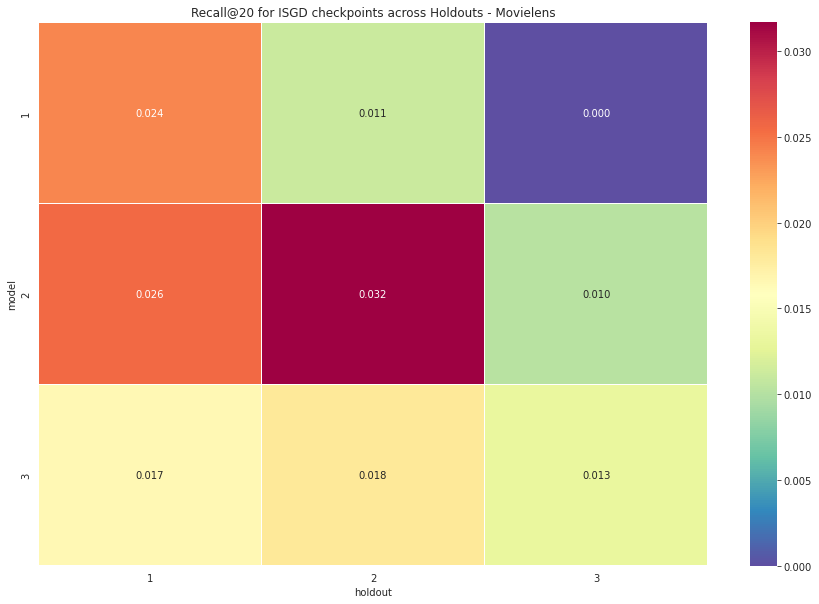

In [66]:
recall_heatmap(df,
    round_point=3,
    title='Recall@20 for ISGD checkpoints across Holdouts - Movielens',
    # filepath='images/heatmaps/movielens_dump/sample_movielens month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [67]:
arecall = avg_recall(df)
arecall

0.022966565510534668

In [68]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.00150602409638554, -0.010552390557705935], -0.004523183230660198)

In [69]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.007146678896277611